In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import keras_tuner as kt   # keras_tuner hỗ trợ tf.keras 
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.layers import Input, Dropout, Dense, Layer, LayerNormalization, MultiHeadAttention, Conv2D, BatchNormalization, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications import DenseNet121

In [2]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# ----------------------- DENSENET MODEL -----------------------
def build_densenet_model(num_classes=1):
    """
    Xây dựng model DenseNet121 cho binary classification
    Tương tự PyTorch: model = models.densenet121(pretrained=True)
                     model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    """
    # Load DenseNet121 với pretrained weights (tương tự pretrained=True)
    base_model = DenseNet121(
        weights='imagenet',  # pretrained=True
        include_top=False,   # bỏ classification head mặc định
        input_shape=(32, 32, 3)
    )
    
    # Thêm classification head mới
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # tương tự AdaptiveAvgPool2d trong PyTorch
    outputs = Dense(num_classes, activation='sigmoid')(x)  # tương tự nn.Linear
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

C:\Users\hp\AppData\Local\Temp\ipykernel_19120\927846416.py:58: DtypeWarning: Columns (7,12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('metadata.csv')


Train size: 34603
Validation size: 4450
Test size: 10381
train 34603 validation 4450 test 10381 test_diagnosis_processed 10381


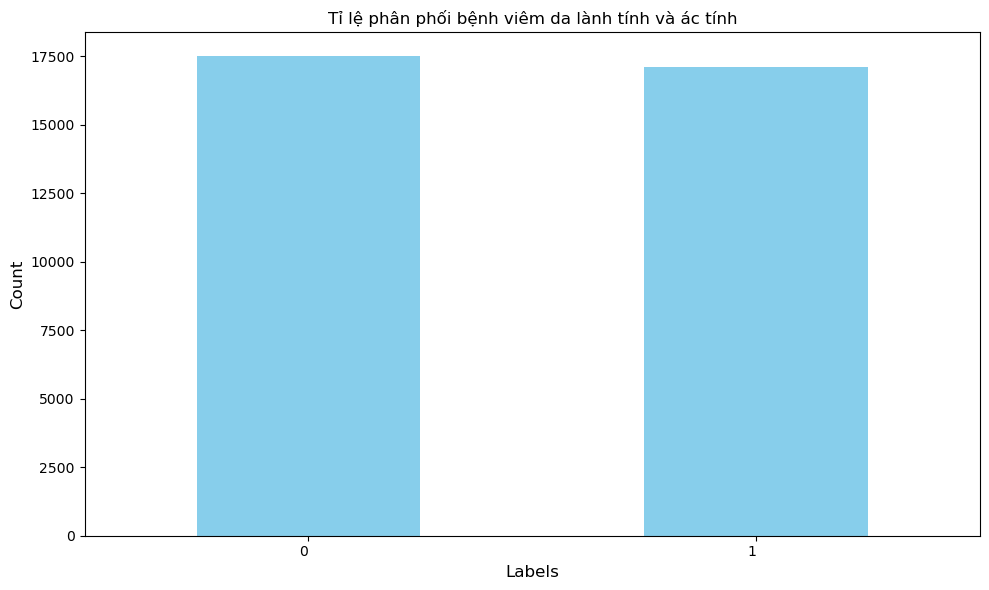

In [3]:
train_data_dir = '../Dataset_Final/train/'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        fpath = fpath.replace("\\", "/")
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
test_data_dir = '../Dataset_Final/test/'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        fpath = fpath.replace("\\", "/")
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
train_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
val_data_dir = '../Dataset_Final/val/'
filepaths = []
labels = []
folds = os.listdir(val_data_dir)
for fold in folds:
    foldpath = os.path.join(val_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        fpath = fpath.replace("\\", "/")
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)
train_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)
df = pd.read_csv('metadata.csv')
df
df['diagnosis_processed'] = df['diagnosis_processed'].apply(lambda x: 0 if x == 'Benign' else 1)
train_df = df[df['dataset_split'] == 'train']  
valid_df = df[df['dataset_split'] == 'val'] 
test_df = df[df['dataset_split'] == 'test']  
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")
test_labels = test_df['diagnosis_processed'].values 
print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0],'test_diagnosis_processed', test_labels.shape[0])
label_counts = train_df['diagnosis_processed'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color= 'skyblue')
plt.title('Tỉ lệ phân phối bệnh viêm da lành tính và ác tính')
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Kích thước ảnh cho DenseNet
IMG_SIZE = (32, 32)  # DenseNet yêu cầu 224x224
TRAIN_BATCH_SIZE = 32
VALID_TEST_BATCH_SIZE = 32

train_dir = '../Dataset_Final/train/'
valid_dir = '../Dataset_Final/val/'
test_dir = '../Dataset_Final/test/'

# Data generator cho training với augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Data generator cho validation và test (chỉ rescale)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Cập nhật generators với kích thước mới
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)
valid_gen = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=VALID_TEST_BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)
test_gen = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=VALID_TEST_BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)
# Kiểm tra kết quả
print("Training generator:")
print(f"Classes: {train_gen.class_indices}")
print(f"Samples: {train_gen.samples}")
print(f"Batch size: {train_gen.batch_size}")
print(f"Number of batches: {len(train_gen)}")
print("\n")

print("Validation generator:")
print(f"Classes: {valid_gen.class_indices}")
print(f"Samples: {valid_gen.samples}")
print(f"Batch size: {valid_gen.batch_size}")
print(f"Number of batches: {len(valid_gen)}")
print("\n")

print("Test generator:")
print(f"Classes: {test_gen.class_indices}")
print(f"Samples: {test_gen.samples}")
print(f"Batch size: {test_gen.batch_size}")
print(f"Number of batches: {len(test_gen)}")
# Kiểm tra kết quả
print("Training generator:")
print(f"Classes: {train_gen.class_indices}")
print(f"Samples: {train_gen.samples}")
print(f"Batch size: {train_gen.batch_size}")
print(f"Number of batches: {len(train_gen)}")

Found 34603 images belonging to 2 classes.
Found 4450 images belonging to 2 classes.
Found 10381 images belonging to 2 classes.
Training generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 34603
Batch size: 32
Number of batches: 1082


Validation generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 4450
Batch size: 32
Number of batches: 140


Test generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 10381
Batch size: 32
Number of batches: 325
Training generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 34603
Batch size: 32
Number of batches: 1082


In [5]:
# Đếm số lượng mẫu cho mỗi class trong training
if hasattr(train_gen, 'classes'):
    train_classes = train_gen.classes
    unique, counts = np.unique(train_classes, return_counts=True)
    print("Samples per class:")
    for class_idx, count in zip(unique, counts):
        class_name = [name for name, idx in train_gen.class_indices.items() if idx == class_idx][0]
        print(f"  {class_name}: {count}")
print("\n")

print("Validation generator:")
print(f"Classes: {valid_gen.class_indices}")
print(f"Samples: {valid_gen.samples}")
print(f"Batch size: {valid_gen.batch_size}")
print(f"Number of batches: {len(valid_gen)}")

if hasattr(valid_gen, 'classes'):
    valid_classes = valid_gen.classes
    unique, counts = np.unique(valid_classes, return_counts=True)
    print("Samples per class:")
    for class_idx, count in zip(unique, counts):
        class_name = [name for name, idx in valid_gen.class_indices.items() if idx == class_idx][0]
        print(f"  {class_name}: {count}")
print("\n")

print("Test generator:")
print(f"Classes: {test_gen.class_indices}")
print(f"Samples: {test_gen.samples}")
print(f"Batch size: {test_gen.batch_size}")
print(f"Number of batches: {len(test_gen)}")

Samples per class:
  Benign: 17500
  Malignant: 17103


Validation generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 4450
Batch size: 32
Number of batches: 140
Samples per class:
  Benign: 2250
  Malignant: 2200


Test generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 10381
Batch size: 32
Number of batches: 325


In [6]:
if hasattr(test_gen, 'classes'):
    test_classes = test_gen.classes
    unique, counts = np.unique(test_classes, return_counts=True)
    print("Samples per class:")
    for class_idx, count in zip(unique, counts):
        class_name = [name for name, idx in test_gen.class_indices.items() if idx == class_idx][0]
        print(f"  {class_name}: {count}")
def process_train_gen(train_gen):
    # Duyệt qua từng batch trong train_gen
    while True:
        x_batch, y_batch = next(train_gen)
      
        yield x_batch, y_batch

def process_valid_test_gen(valid_test_gen):
    # Duyệt qua từng batch trong train_gen
    while True:
        x_batch, y_batch = next(valid_test_gen)
        
        yield x_batch, y_batch

Samples per class:
  Benign: 5250
  Malignant: 5131


In [7]:
train_gen = process_train_gen(train_gen)
valid_gen = process_valid_test_gen(valid_gen)
test_gen = process_valid_test_gen(test_gen)
import math
train_steps = math.ceil(train_df.shape[0] / TRAIN_BATCH_SIZE)
validation_steps = math.ceil(valid_df.shape[0] / VALID_TEST_BATCH_SIZE)
test_steps = math.ceil(test_df.shape[0] / VALID_TEST_BATCH_SIZE)

In [8]:
# Xây dựng model DenseNet
model = build_densenet_model(num_classes=1)

# Optimizer
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.0000001, weight_decay=1.9091e-06
)

model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 38, 38, 3)         │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 16, 16, 64)        │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 16, 16, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 16, 16, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 18, 18, 64)        │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 8, 8, 64)          │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 8, 8, 64)          │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 8, 8, 64)          │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 8, 8, 128)         │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 8, 8, 128)         │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 8, 8, 128)         │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 8, 8, 32)          │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 8, 8, 96)          │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [9]:
weight_path = "{}_weights.best.weights.h5".format('deepderma_densenet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only=True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

reduce = ReduceLROnPlateau(
        monitor="val_loss", factor=0.1,
        patience=2, verbose=1
    )

# Thêm CSVLogger vào callbacks_list
csv_logger = CSVLogger('training_logger_densenet.csv', separator=',', append=False)

callbacks_list = [checkpoint, early, reduce, csv_logger]

In [10]:
history = model.fit(train_gen,  
            steps_per_epoch=train_steps,
            validation_data=valid_gen,  
            validation_steps=validation_steps,
            epochs=100,
            callbacks=callbacks_list
           )

Epoch 1/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.5329 - loss: 0.8050
Epoch 1: val_loss improved from inf to 0.90535, saving model to deepderma_densenet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1034s 873ms/step - accuracy: 0.5329 - loss: 0.8050 - val_accuracy: 0.5611 - val_loss: 0.9053 - learning_rate: 1.0000e-07
Epoch 2/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.5643 - loss: 0.7651
Epoch 2: val_loss improved from 0.90535 to 0.82743, saving model to deepderma_densenet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1046s 968ms/step - accuracy: 0.5643 - loss: 0.7651 - val_accuracy: 0.5933 - val_loss: 0.8274 - learning_rate: 1.0000e-07
Epoch 3/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5943 - loss: 0.7293
Epoch 3: val_loss improved from 0.82743 to 0.80547, saving model to deepderma_densenet_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1213s 1s/step - accuracy: 0.5943 - loss: 0.7293 - val_accuracy: 0.

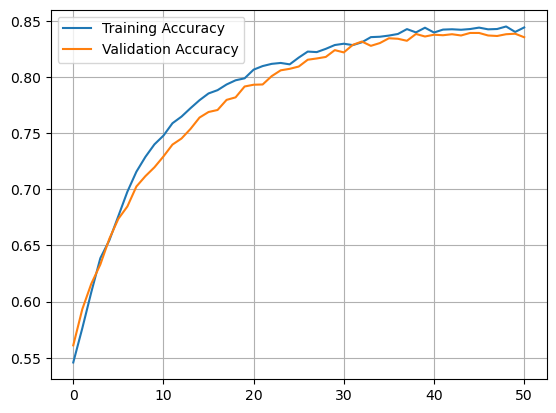

In [11]:
# DenseNet
def plot_history_accuracy(history):
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_accuracy(history=history)

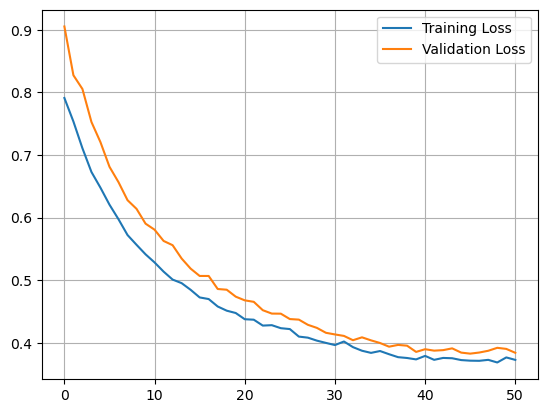

In [12]:
# DenseNet
def plot_history_loss(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_loss(history=history)

In [44]:
# DenseNet
predictions = model.predict(test_gen, steps=test_steps, verbose=True)
predictions = (predictions >= 0.5).astype(int)

325/325 ━━━━━━━━━━━━━━━━━━━━ 182s 563ms/step


In [45]:
# Kiểm tra kích thước
print(f"Test labels shape: {test_labels.shape}")
print(f"Predictions shape: {predictions.shape}")

Test labels shape: (10381,)
Predictions shape: (10381, 1)


In [46]:
# Cắt cho khớp kích thước
min_length = min(len(test_labels), len(predictions))
test_labels = test_labels[:min_length]
predictions = predictions[:min_length]
print(f"After trimming - Test labels: {test_labels.shape}, Predictions: {predictions.shape}")

After trimming - Test labels: (10381,), Predictions: (10381, 1)


In [47]:
# Sau đó mới tính classification report
print(classification_report(test_labels, predictions, target_names=['Benign (Class 0)', 'Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.82      0.84      0.83      5250
Malignant (Class 1)       0.83      0.82      0.83      5131

           accuracy                           0.83     10381
          macro avg       0.83      0.83      0.83     10381
       weighted avg       0.83      0.83      0.83     10381



In [48]:
# Classification report dạng dict
report_dict = classification_report(
    test_labels, 
    predictions, 
    target_names=['Benign (Class 0)', 'Malignant (Class 1)'], 
    output_dict=True
)

# Chuyển thành DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# In ra bảng trong notebook
print(report_df)

# Lưu ra file CSV
report_df.to_csv("classification_report_densenet.csv", index=True)
print("Classification report đã được lưu vào classification_report_densenet.csv")

                     precision    recall  f1-score       support
Benign (Class 0)      0.824813  0.842095  0.833365   5250.000000
Malignant (Class 1)   0.834893  0.816995  0.825847   5131.000000
accuracy              0.829689  0.829689  0.829689      0.829689
macro avg             0.829853  0.829545  0.829606  10381.000000
weighted avg          0.829796  0.829689  0.829649  10381.000000
Classification report đã được lưu vào classification_report_densenet.csv


325/325 ━━━━━━━━━━━━━━━━━━━━ 203s 626ms/step

ROC Analysis:
y_test shape for ROC: (10381,)
y_pred_prob shape: (10381,)


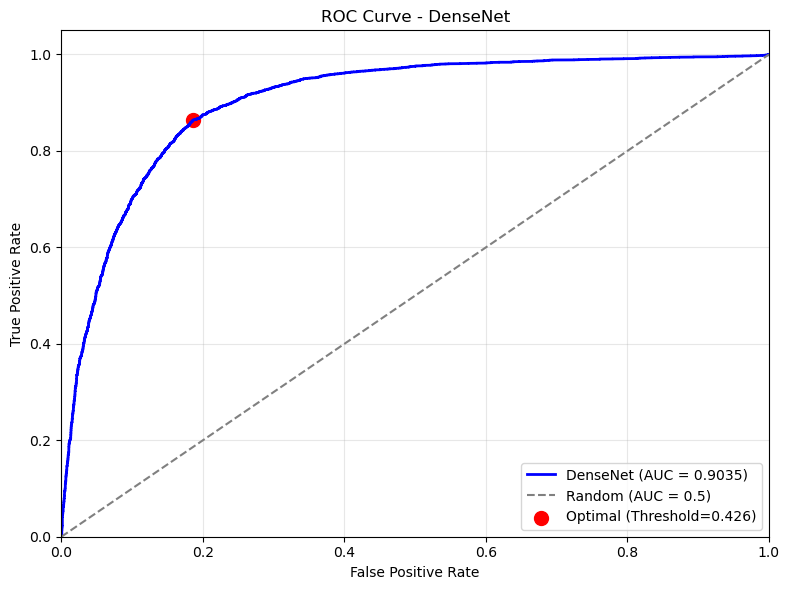

In [60]:
# ==================== THÊM PHẦN NÀY VÀO SAU KHI CÓ predictions ====================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc

# 1. Lấy predictions probabilities (chưa threshold)
# Đảm bảo dùng model.predict lại để lấy xác suất
y_pred_prob = model.predict(test_gen, steps=test_steps, verbose=True)

# 2. Flatten nếu cần
if len(y_pred_prob.shape) > 1 and y_pred_prob.shape[1] == 1:
    y_pred_prob = y_pred_prob.ravel()

# 3. Cắt cho khớp với test_labels (giống như bạn đã làm với predictions)
min_length = min(len(test_labels), len(y_pred_prob))
y_test_roc = test_labels[:min_length].copy()  # Tạo bản sao để không ảnh hưởng biến cũ
y_pred_prob = y_pred_prob[:min_length]

print(f"\nROC Analysis:")
print(f"y_test shape for ROC: {y_test_roc.shape}")
print(f"y_pred_prob shape: {y_pred_prob.shape}")

# 4. Tính ROC curve
fpr, tpr, thresholds = roc_curve(y_test_roc, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 5. Tìm điểm tối ưu (Youden's J)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_idx]
optimal_fpr = fpr[youden_idx]
optimal_tpr = tpr[youden_idx]

# 6. Vẽ ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'DenseNet (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')
plt.scatter(optimal_fpr, optimal_tpr, color='red', s=100, 
           label=f'Optimal (Threshold={optimal_threshold:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DenseNet')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Lưu ROC data vào CSV
roc_points_df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'Threshold': thresholds
})
roc_points_df.to_csv('ROC_curve_points_DenseNet.csv', index=False)

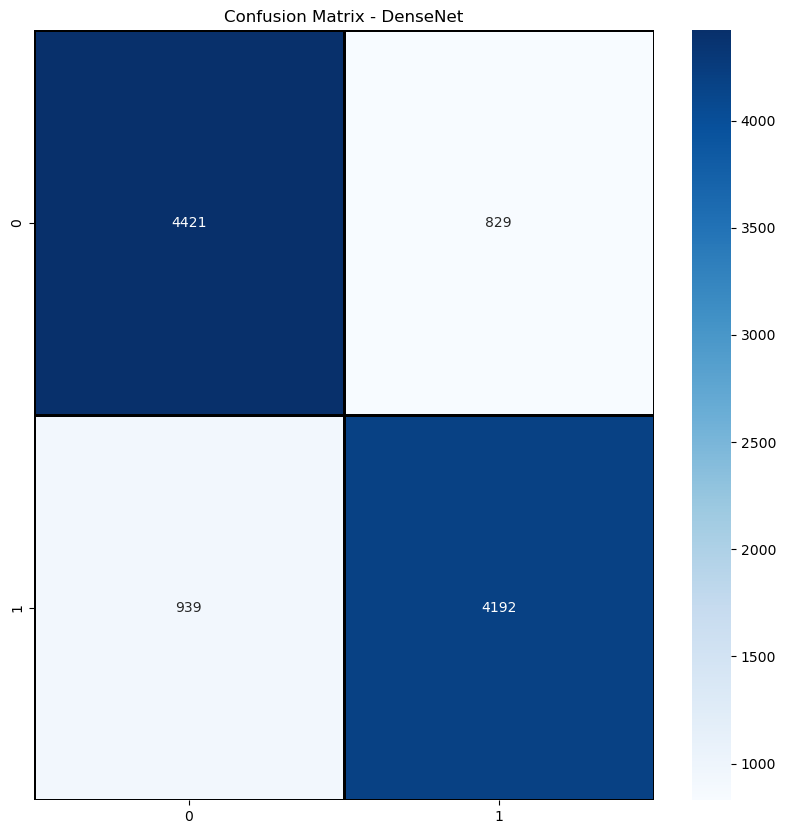

In [61]:
# DenseNet
cm = confusion_matrix(test_labels, predictions)
cm
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
# DenseNet
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='d', xticklabels=cm.columns, yticklabels=cm.index)
plt.title('Confusion Matrix - DenseNet')
plt.show()